In [1]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, EfficientNetB7, EfficientNetB3
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import cv2
import seaborn as sns
from matplotlib import pyplot as plt
import keras.layers as L
from keras import optimizers, losses, metrics, Model
from keras.callbacks import EarlyStopping
from keras.models import load_model
import shutil
import datetime
import os
from tensorflow.keras.models import load_model
import pickle

random.seed()

2024-02-23 18:28:57.924745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 18:28:57.924816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 18:28:57.976554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 18:28:58.090165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 18:28:59.175554: W tensorflow/compiler/tf2

# Seperate The Train immages into Folders

In [3]:
def copy_images_to_class_directories(directory, csv_file):
    # Read CSV file
    df = pd.read_csv(csv_file)
    label_dict = dict(zip(df['Image'], df['Label']))

    # Create directories for each class (0 and 1) in the Separated directory
    separated_directory = os.path.join(os.path.dirname(directory), 'Separated')
    for class_label in ['0', '1']:
        os.makedirs(os.path.join(separated_directory, class_label), exist_ok=True)

    # Iterate through images and copy them to respective directories
    for file in os.listdir(directory):
        if file.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            image_path = os.path.join(directory, file)
            image_id = file  # Extract image ID from the file name
            label = label_dict.get(image_id, 'Unknown')
            label = '1' if label == "Mitosis" else '0'
            destination_directory = os.path.join(separated_directory, label)
            shutil.copy(image_path, destination_directory)

directory = 'Round 2 Data/Training Image'
csv_file = 'Round 2 Data/Training.csv'
copy_images_to_class_directories(directory, csv_file)

In [15]:
import os
import cv2

# Path to the directory containing subfolders 0 and 1
input_dir = "Round 1 Data/Separated"

# Path to the directory to save the 512x512 patches
output_dir = "Round 1 Data/512x512 Separated"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to split image into 1024x1024 patches and resize them to 512x512
def split_and_resize(image):
    patches = []
    for i in range(0, image.shape[0], 1024):
        for j in range(0, image.shape[1], 1024):
            patch = image[i:i+1024, j:j+1024]
            # Check if the patch size is smaller than 512x512
            if patch.shape[0] >= 512 and patch.shape[1] >= 512:
                # Resize the patch to 512x512
                patch = cv2.resize(patch, (512, 512))
                patches.append(patch)
    return patches

# Loop through subfolders (0 and 1)
for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    output_label_dir = os.path.join(output_dir, label)
    os.makedirs(output_label_dir, exist_ok=True)
    
    # Loop through images in each subfolder
    for filename in os.listdir(label_dir):
        image_path = os.path.join(label_dir, filename)
        
        # Read the 4K image
        image = cv2.imread(image_path)
        
        # Split the image into 1024x1024 patches and resize them to 512x512
        patches = split_and_resize(image)
        
        # Save the patches to the output directory
        for i, patch in enumerate(patches):
            output_filename = os.path.splitext(filename)[0] + f"_patch_{i}.jpg"
            output_path = os.path.join(output_label_dir, output_filename)
            cv2.imwrite(output_path, patch)

print("Image splitting and saving complete.")


Image splitting and saving complete.


# Augment the seperated Immages

In [10]:
import os
import cv2
import numpy as np

# Function to flip and rotate images
def augment_image(input_directory, output_directory, class_label, filename):
    input_class_directory = os.path.join(input_directory, class_label)
    output_class_directory = os.path.join(output_directory, class_label)
    os.makedirs(output_class_directory, exist_ok=True)
    
    image_path = os.path.join(input_class_directory, filename)
    image = cv2.imread(image_path)
    
    if image is not None:
        # Flip horizontally, vertically, and rotate
        flipped_horizontal = cv2.flip(image, 1)
        flipped_vertical = cv2.flip(image, 0)
        rotated_90_clockwise = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        rotated_90_counterclockwise = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        # Save augmented images
        output_filename_horizontal = os.path.splitext(filename)[0] + '_flipped_horizontal.jpg'
        output_filename_vertical = os.path.splitext(filename)[0] + '_flipped_vertical.jpg'
        output_filename_rotated_clockwise = os.path.splitext(filename)[0] + '_rotated_clockwise.jpg'
        output_filename_rotated_counterclockwise = os.path.splitext(filename)[0] + '_rotated_counterclockwise.jpg'
        
        output_path_horizontal = os.path.join(output_class_directory, output_filename_horizontal)
        output_path_vertical = os.path.join(output_class_directory, output_filename_vertical)
        output_path_rotated_clockwise = os.path.join(output_class_directory, output_filename_rotated_clockwise)
        output_path_rotated_counterclockwise = os.path.join(output_class_directory, output_filename_rotated_counterclockwise)
        
        cv2.imwrite(output_path_horizontal, flipped_horizontal)
        cv2.imwrite(output_path_vertical, flipped_vertical)
        cv2.imwrite(output_path_rotated_clockwise, rotated_90_clockwise)
        cv2.imwrite(output_path_rotated_counterclockwise, rotated_90_counterclockwise)
        
        print(f"Augmented images saved for {filename}")
    else:
        print(f"Unable to read image: {image_path}")

# Function to perform image augmentation for each class
def parallel_augmentation(input_directory, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    for class_label in ['0', '1']:
        input_class_directory = os.path.join(input_directory, class_label)
        output_class_directory = os.path.join(output_directory, class_label)
        filenames = os.listdir(input_class_directory)
        for filename in filenames:
            augment_image(input_directory, output_directory, class_label, filename)

# Example usage
input_directory = 'Round 2 Data/Separated'
output_directory = 'Round 2 Data/Augmented'
parallel_augmentation(input_directory, output_directory)


Augmented images saved for 3500_0.png
Augmented images saved for 2500_0.png
Augmented images saved for 2500_4000.png
Augmented images saved for 0_3000.png
Augmented images saved for 5500_0.png
Augmented images saved for 0_500.png
Augmented images saved for 1000_2500.png
Augmented images saved for 7000_4500.png
Augmented images saved for 2000_0.png
Augmented images saved for 2500_1000.png
Augmented images saved for 6500_500.png
Augmented images saved for 1500_0.png
Augmented images saved for 2500_3500.png
Augmented images saved for 1000_0.png
Augmented images saved for 4000_0.png
Augmented images saved for 7000_500.png
Augmented images saved for 500_0.png
Augmented images saved for 7000_1500.png
Augmented images saved for 0_1000.png
Augmented images saved for 0_4500.png
Augmented images saved for 6000_0.png
Augmented images saved for 3000_0.png
Augmented images saved for 0_2000.png
Augmented images saved for 6500_5000.png
Augmented images saved for 2500_2500.png
Augmented images saved f

# Resize Augmented Immages

In [7]:
import os
import cv2

# Function to resize image using Lanczos interpolation
def resize_image(image_path, output_folder):
    # Load image
    img = cv2.imread(image_path)
    
    # Resize image using Lanczos interpolation
    resized_img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_LANCZOS4)
    
    # Determine output subfolder based on image name
    subfolder = "1" if "1" in image_path else "0"
    
    # Save resized image to the correct subfolder
    output_path = os.path.join(output_folder, subfolder, os.path.basename(image_path))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, resized_img)

# Path to the folder containing images
input_folder = 'Round 2 Data/Training Image'

# Create output folder if it doesn't exist
output_folder = 'Round 2 Data/512x512 Augmented'

# Iterate over each image in the '0' and '1' subdirectories
for root, dirs, files in os.walk(input_folder):
    for dir_name in dirs:
        if dir_name in ['0', '1']:
            subdir_path = os.path.join(root, dir_name)
            for filename in os.listdir(subdir_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    image_path = os.path.join(subdir_path, filename)
                    resize_image(image_path, output_folder)
                    print(f"Resized {filename} and saved to {output_folder}")

print("All images resized and saved successfully.")


All images resized and saved successfully.


# Use a pretrained efficent net b0 and transfer learn it on the Round 1 Immage Patches for efficent feature extraction

2024-02-23 18:29:01.890175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 18:29:02.080982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 18:29:02.081070: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 18:29:02.085307: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 18:29:02.085362: I external/local_xla/xla/stream_executor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 512, 512, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 512, 512, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 512, 512, 3)          0         ['normalization[0][0]']   

2024-02-23 18:29:05.964363: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/20


2024-02-23 18:29:10.921965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-23 18:29:12.050487: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-23 18:29:12.278880: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-23 18:29:13.325692: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa11a789e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-23 18:29:13.325738: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-02-23 18:29:13.338043: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash 

2169/2169 [==============================] - 62s 25ms/step - loss: 0.3285 - binary_accuracy: 0.7792 - val_loss: 0.2787 - val_binary_accuracy: 0.8232
Epoch 2/20
2169/2169 [==============================] - 51s 24ms/step - loss: 0.2858 - binary_accuracy: 0.8211 - val_loss: 0.2798 - val_binary_accuracy: 0.8306
Epoch 3/20
2169/2169 [==============================] - 51s 24ms/step - loss: 0.2686 - binary_accuracy: 0.8359 - val_loss: 0.2934 - val_binary_accuracy: 0.7956
Epoch 4/20
2169/2169 [==============================] - 51s 23ms/step - loss: 0.2619 - binary_accuracy: 0.8290 - val_loss: 0.2850 - val_binary_accuracy: 0.8214
Epoch 5/20
2169/2169 [==============================] - 51s 24ms/step - loss: 0.2472 - binary_accuracy: 0.8432 - val_loss: 0.2604 - val_binary_accuracy: 0.8250
Epoch 1/20


2024-02-23 18:34:12.646272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2169/2169 [==============================] - 168s 69ms/step - loss: 0.2514 - binary_accuracy: 0.8368 - val_loss: 0.2575 - val_binary_accuracy: 0.8343
Epoch 2/20
2169/2169 [==============================] - 148s 68ms/step - loss: 0.2333 - binary_accuracy: 0.8580 - val_loss: 0.2576 - val_binary_accuracy: 0.8250
Epoch 3/20
2169/2169 [==============================] - 149s 68ms/step - loss: 0.2214 - binary_accuracy: 0.8700 - val_loss: 0.2539 - val_binary_accuracy: 0.8398
Epoch 4/20
2169/2169 [==============================] - 155s 71ms/step - loss: 0.2132 - binary_accuracy: 0.8677 - val_loss: 0.2519 - val_binary_accuracy: 0.8343
Epoch 5/20
2169/2169 [==============================] - 154s 71ms/step - loss: 0.2071 - binary_accuracy: 0.8718 - val_loss: 0.2508 - val_binary_accuracy: 0.8306
Epoch 6/20
2169/2169 [==============================] - 153s 71ms/step - loss: 0.1938 - binary_accuracy: 0.8820 - val_loss: 0.2581 - val_binary_accuracy: 0.8324
INFO:tensorflow:Assets written to: trained_mo

INFO:tensorflow:Assets written to: trained_model/assets


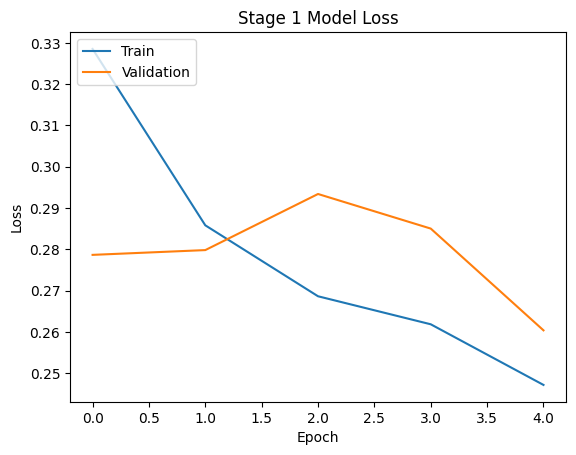

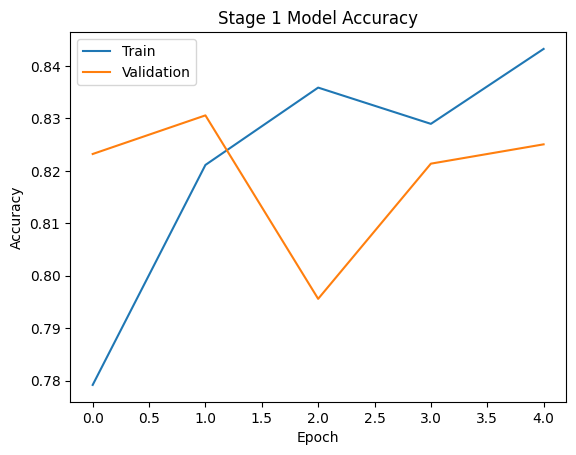

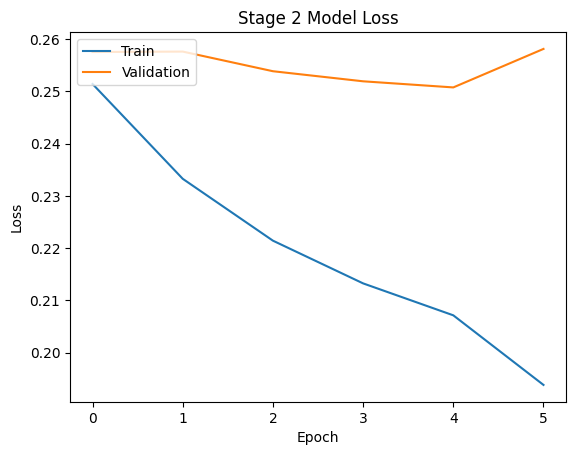

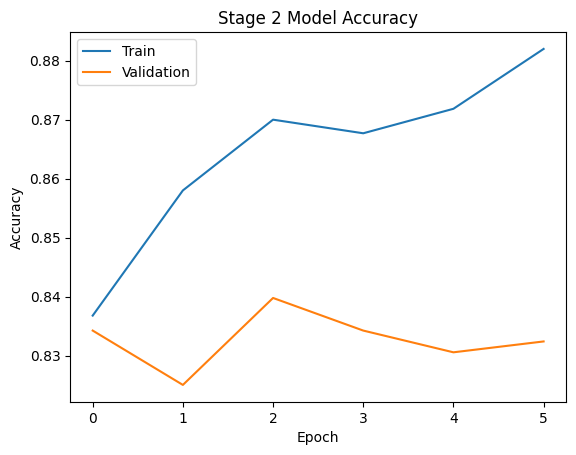

543/543 [==============================] - 9s 15ms/step


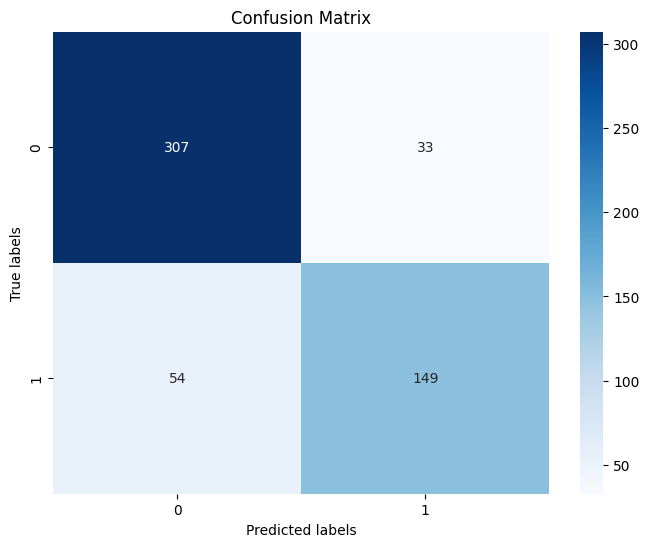

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
import random
import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Global variables
BATCH_SIZE = 1
LEARNING_RATE_STAGE1 = 0.0001
LEARNING_RATE_STAGE2 = 0.000001
NEURONS = 128
OPTIMIZER = 'Adam'

# Set random seed for reproducibility
random.seed()

# Load pre-trained EfficientNet-B0 model without top classification layers
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification layers for binary classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(NEURONS, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)

model.summary()

# Compile the model for stage 1 training
model.compile(optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE1),
              loss=tf.losses.BinaryFocalCrossentropy(alpha=0.3938, gamma=0.5),
              metrics=[tf.metrics.BinaryAccuracy()])
# Load file paths
filesArray = []
for path, subdirs, files in os.walk("Round 1 Data/512x512 Separated"):
    for name in files:
        filesArray.append(os.path.join(path, name))

# Shuffle the list of file paths
random.shuffle(filesArray)

# Calculate the total number of samples
num_samples = len(filesArray)

# Define the size of the test set
test_size = 1 + int(0.2 * num_samples)  # 25% of the data for testing

# Split data into training and testing sets
train_files = filesArray[test_size:]
test_files = filesArray[:test_size]

# Function to load and preprocess images
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (512, 512))
    return image

# Function to load and preprocess images with label
def load_image_with_label(file_path, label):
    image = load_image(file_path)
    return image, label

# Convert training and testing datasets to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, [int(os.path.basename(os.path.dirname(file_path))) for file_path in train_files]))
train_dataset = train_dataset.map(lambda x, y: (load_image(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(buffer_size=300).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_files, [int(os.path.basename(os.path.dirname(file_path))) for file_path in test_files]))
test_dataset = test_dataset.map(lambda x, y: (load_image(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Define custom callback for TensorBoard with custom log file name
class CustomTensorBoard(tf.keras.callbacks.TensorBoard):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.log_dir = self._get_logs_dir(self.log_dir)

    def _get_logs_dir(self, logs_dir):
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        log_name = f"batch_size_{BATCH_SIZE}_lr_{LEARNING_RATE_STAGE1}_neurons_{NEURONS}_optimizer_{OPTIMIZER}_{current_time}"
        return os.path.join(logs_dir, log_name)

# Define TensorBoard callback with custom log file name
log_dir = './logs'  # Directory to store TensorBoard logs
tensorboard_callback = CustomTensorBoard(log_dir=log_dir)

# Implement Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Stage 1: Train with base model frozen (higher learning rate)
history_stage1 = model.fit(train_dataset, 
                           epochs=20,  # Example number of epochs
                           validation_data=test_dataset, 
                           verbose=1,
                           callbacks=[#tf.keras.callbacks.LearningRateScheduler(lr_scheduler), 
                                      tensorboard_callback, 
                                      early_stopping_callback])

# Unfreeze base model for Stage 2
base_model.trainable = True

# Freeze batch normalization layers
for layer in model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

# Compile the model for stage 2 training
model.compile(optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE2),
              loss=tf.losses.BinaryFocalCrossentropy(alpha=0.3938, gamma=0.5),
              metrics=[tf.metrics.BinaryAccuracy()])

# Stage 2: Train with base model unfrozen (lower learning rate)
history_stage2 = model.fit(train_dataset, 
                           epochs=20,  # Example number of epochs
                           validation_data=test_dataset, 
                           verbose=1,
                           callbacks=[#tf.keras.callbacks.LearningRateScheduler(lr_scheduler), 
                                      tensorboard_callback, 
                                      early_stopping_callback])

# Save the trained model
model.save('trained_model')

# Plot loss vs epoch for stage 1
plt.plot(history_stage1.history['loss'])
plt.plot(history_stage1.history['val_loss'])
plt.title('Stage 1 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot accuracy vs epoch for stage 1
plt.plot(history_stage1.history['binary_accuracy'])
plt.plot(history_stage1.history['val_binary_accuracy'])
plt.title('Stage 1 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss vs epoch for stage 2
plt.plot(history_stage2.history['loss'])
plt.plot(history_stage2.history['val_loss'])
plt.title('Stage 2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot accuracy vs epoch for stage 2
plt.plot(history_stage2.history['binary_accuracy'])
plt.plot(history_stage2.history['val_binary_accuracy'])
plt.title('Stage 2 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate predictions and create confusion matrix
predictions = model.predict(test_dataset)
y_true = np.concatenate([y for _, y in test_dataset], axis=0)
y_pred = np.round(predictions).astype(int)
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Using Model Trained On Round 1 Data and then traing on Round 2 Data

Epoch 1/7


2024-02-23 18:50:16.042477: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


296/296 [==============================] - 13s 27ms/step - loss: 0.5945 - binary_accuracy: 0.6959 - val_loss: 0.4948 - val_binary_accuracy: 0.8235
Epoch 2/7
296/296 [==============================] - 7s 23ms/step - loss: 0.5210 - binary_accuracy: 0.7534 - val_loss: 0.3216 - val_binary_accuracy: 0.8824
Epoch 3/7
296/296 [==============================] - 7s 23ms/step - loss: 0.4672 - binary_accuracy: 0.7770 - val_loss: 0.3694 - val_binary_accuracy: 0.8235
Epoch 4/7
296/296 [==============================] - 7s 23ms/step - loss: 0.3998 - binary_accuracy: 0.7872 - val_loss: 0.2711 - val_binary_accuracy: 0.8529
Epoch 5/7
296/296 [==============================] - 7s 23ms/step - loss: 0.3828 - binary_accuracy: 0.8311 - val_loss: 0.2727 - val_binary_accuracy: 0.8824
Epoch 1/20
296/296 [==============================] - 39s 72ms/step - loss: 0.2023 - binary_accuracy: 0.8277 - val_loss: 0.1907 - val_binary_accuracy: 0.8824
Epoch 2/20
296/296 [==============================] - 20s 68ms/step - l

INFO:tensorflow:Assets written to: trained_model_round2/assets


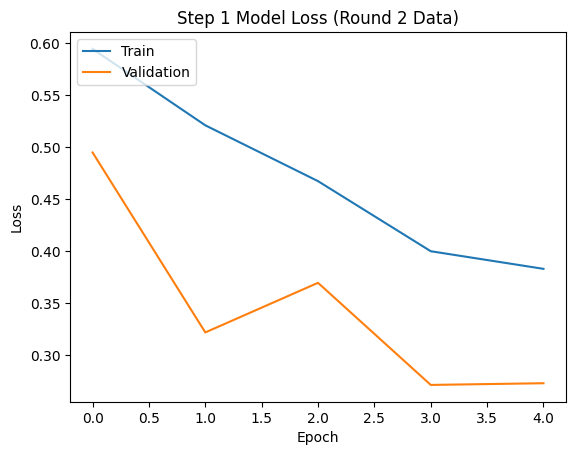

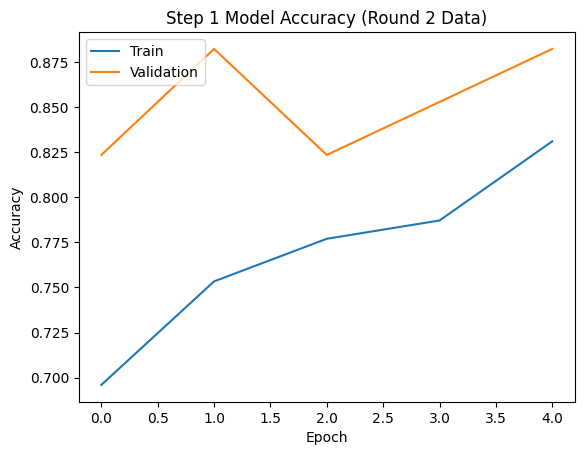

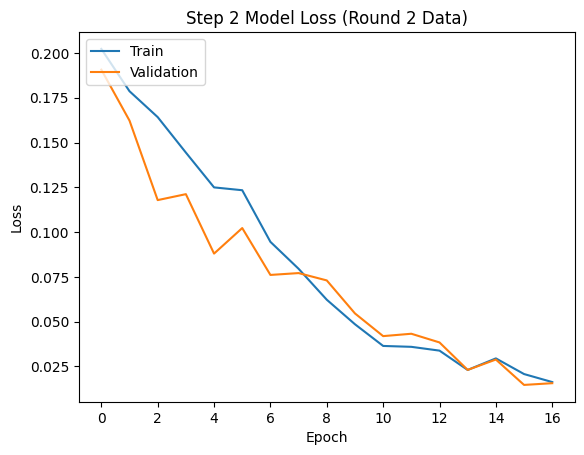

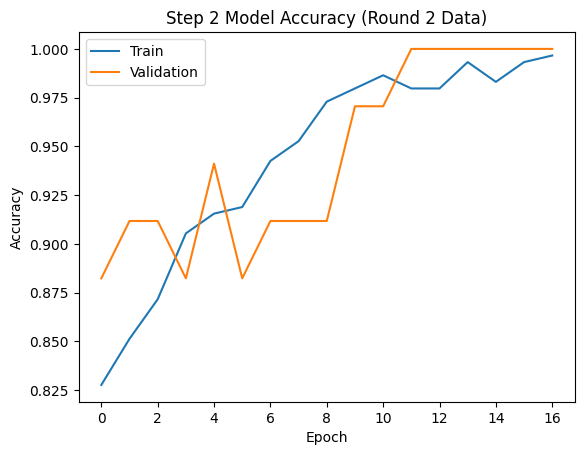

34/34 [==============================] - 2s 17ms/step


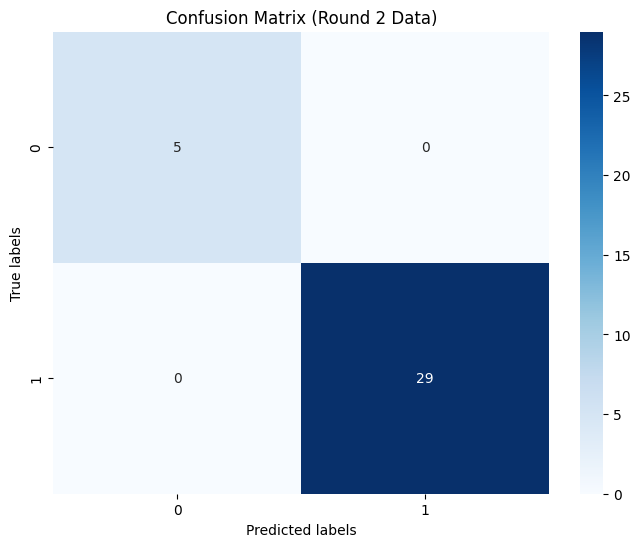

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
import random
import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Global variables
BATCH_SIZE = 1
LEARNING_RATE_STAGE1 = 0.0003
LEARNING_RATE_STAGE2 = 0.000002

# Load the pre-trained model
model = load_model('trained_model')

# Freeze layers except the last 3 layers for step 1 training
for layer in model.layers[:-3]:
    layer.trainable = False

# Compile the model for step 1 training
model.compile(optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE1),
              loss=tf.losses.BinaryFocalCrossentropy(alpha=0.59, gamma=0.06),
              metrics=[tf.metrics.BinaryAccuracy()])

# Load file paths for Round 2 Data/Separated
filesArray_round2 = []
for path, subdirs, files in os.walk("Round 2 Data/512x512 Augmented"):
    for name in files:
        filesArray_round2.append(os.path.join(path, name))

# Shuffle the list of file paths
random.shuffle(filesArray_round2)

# Calculate the total number of samples
num_samples_round2 = len(filesArray_round2)

# Define the size of the test set
test_size_round2 = 1 + int(0.1 * num_samples_round2)  # 25% of the data for testing

# Split data into training and testing sets for Round 2 Data/Separated
train_files_round2 = filesArray_round2[test_size_round2:]
test_files_round2 = filesArray_round2[:test_size_round2]

# Function to load and preprocess images
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (512, 512))
    return image

# Function to load and preprocess images with label
def load_image_with_label(file_path, label):
    image = load_image(file_path)
    return image, label

# Convert training and testing datasets to TensorFlow datasets for Round 2 Data/Separated
train_dataset_round2 = tf.data.Dataset.from_tensor_slices((train_files_round2, [int(os.path.basename(os.path.dirname(file_path))) for file_path in train_files_round2]))
train_dataset_round2 = train_dataset_round2.map(lambda x, y: (load_image(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset_round2 = train_dataset_round2.batch(BATCH_SIZE).shuffle(buffer_size=300).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset_round2 = tf.data.Dataset.from_tensor_slices((test_files_round2, [int(os.path.basename(os.path.dirname(file_path))) for file_path in test_files_round2]))
test_dataset_round2 = test_dataset_round2.map(lambda x, y: (load_image(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset_round2 = test_dataset_round2.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Implement Early Stopping for step 1 training
early_stopping_callback_stage1_round2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with step 1 training on Round 2 Data/Separated
history_stage1_round2 = model.fit(train_dataset_round2, 
                                  epochs=7,  # Example number of epochs
                                  validation_data=test_dataset_round2, 
                                  verbose=1,
                                  callbacks=[#tf.keras.callbacks.LearningRateScheduler(lr_scheduler), 
                                             early_stopping_callback_stage1_round2])

# Unfreeze layers for step 2 training
for layer in model.layers:
    layer.trainable = True

# Freeze batch normalization layers
for layer in model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

# Compile the model for step 2 training
model.compile(optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE2),
              loss=tf.losses.BinaryFocalCrossentropy(alpha=0.59, gamma=1),
              metrics=[tf.metrics.BinaryAccuracy()])

# Implement Early Stopping for step 2 training
early_stopping_callback_stage2_round2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Monitor validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with step 2 training on Round 2 Data/Separated
history_stage2_round2 = model.fit(train_dataset_round2, 
                                  epochs=20,  # Example number of epochs
                                  validation_data=test_dataset_round2, 
                                  verbose=1,
                                  callbacks=[#tf.keras.callbacks.LearningRateScheduler(lr_scheduler), 
                                             early_stopping_callback_stage2_round2])

# Save the trained model for Round 2 Data/Separated
model.save('trained_model_round2')

# Plot loss vs epoch for step 1 training on Round 2 Data/Separated
plt.plot(history_stage1_round2.history['loss'])
plt.plot(history_stage1_round2.history['val_loss'])
plt.title('Step 1 Model Loss (Round 2 Data)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot accuracy vs epoch for step 1 training on Round 2 Data/Separated
plt.plot(history_stage1_round2.history['binary_accuracy'])
plt.plot(history_stage1_round2.history['val_binary_accuracy'])
plt.title('Step 1 Model Accuracy (Round 2 Data)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss vs epoch for step 2 training on Round 2 Data/Separated
plt.plot(history_stage2_round2.history['loss'])
plt.plot(history_stage2_round2.history['val_loss'])
plt.title('Step 2 Model Loss (Round 2 Data)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot accuracy vs epoch for step 2 training on Round 2 Data/Separated
plt.plot(history_stage2_round2.history['binary_accuracy'])
plt.plot(history_stage2_round2.history['val_binary_accuracy'])
plt.title('Step 2 Model Accuracy (Round 2 Data)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate predictions and create confusion matrix for Round 2 Data/Separated
predictions_round2 = model.predict(test_dataset_round2)
y_true_round2 = np.concatenate([y for _, y in test_dataset_round2], axis=0)
y_pred_round2 = np.round(predictions_round2).astype(int)
conf_matrix_round2 = confusion_matrix(y_true_round2, y_pred_round2)

# Plot confusion matrix for Round 2 Data/Separated
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_round2, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Round 2 Data)')
plt.show()


# Calculate the AUC and F1 Score

1/1 [==============================] - 0s 23ms/step
F1 Score (All Data): 1.0
AUC (All Data): 1.0


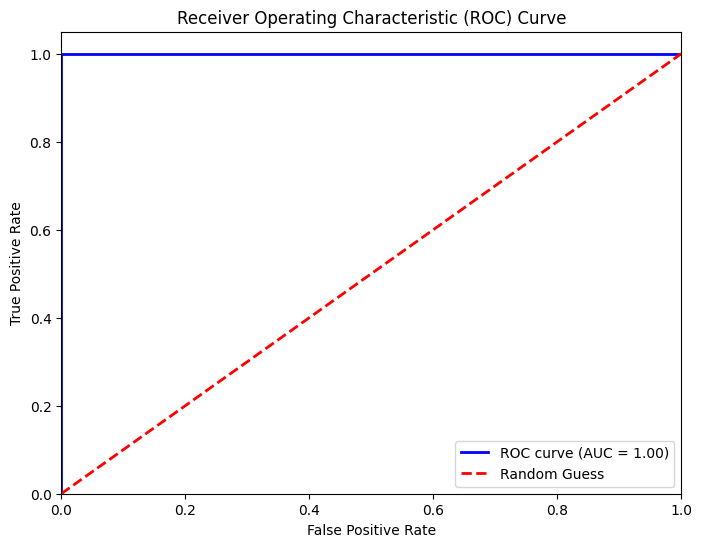

In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Load the pre-trained model
model = tf.keras.models.load_model('trained_model_round2')

# Function to load and preprocess images
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (512, 512))
    return image

# Load file paths for all data
all_files = []
for path, _, files in os.walk("Round 2 Data/512x512 Augmented"):
    for file in files:
        all_files.append(os.path.join(path, file))

# Convert all data to TensorFlow dataset
all_dataset = tf.data.Dataset.from_tensor_slices(all_files)
all_dataset = all_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
all_dataset = all_dataset.batch(1)  # Set batch size to 1 for prediction

# Predict probabilities for all data
all_predicted_probabilities = []
for images in all_dataset:
    predictions = model.predict(images)
    all_predicted_probabilities.extend(predictions.flatten())

# Load true labels for all data
all_true_labels = []
for file_path in all_files:
    label = int(os.path.basename(os.path.dirname(file_path)))
    all_true_labels.append(label)

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_probabilities = np.array(all_predicted_probabilities)

# Calculate F1 score and AUC
f1_score_all_data = f1_score(all_true_labels, np.round(all_predicted_probabilities))
auc_all_data = roc_auc_score(all_true_labels, all_predicted_probabilities)

print("F1 Score (All Data):", f1_score_all_data)
print("AUC (All Data):", auc_all_data)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_true_labels, all_predicted_probabilities)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Resize Testing Immages

In [8]:
import os
import cv2

# Function to resize image using Lanczos interpolation
def resize_image(image_path, output_folder):
    # Load image
    img = cv2.imread(image_path)
    
    # Resize image using Lanczos interpolation
    resized_img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_LANCZOS4)
    
    # Save resized image to the output folder
    output_path = os.path.join(output_folder, os.path.basename(image_path))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, resized_img)

# Path to the folder containing images
input_folder = 'Round 2 Data/Testing Image'

# Create output folder if it doesn't exist
output_folder = 'Round 2 Data/512x512 Testing'

# Iterate over each image in the main directory
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(input_folder, filename)
        resize_image(image_path, output_folder)
        print(f"Resized {filename} and saved to {output_folder}")

print("All images resized and saved successfully.")


Resized 4500_5000.png and saved to Round 2 Data/512x512 Testing
Resized 5000_500.png and saved to Round 2 Data/512x512 Testing
Resized 5000_4000.png and saved to Round 2 Data/512x512 Testing
Resized 3000_1000.png and saved to Round 2 Data/512x512 Testing
Resized 7000_1000.png and saved to Round 2 Data/512x512 Testing
Resized 2500_3000.png and saved to Round 2 Data/512x512 Testing
Resized 1500_5000.png and saved to Round 2 Data/512x512 Testing
Resized 6000_1500.png and saved to Round 2 Data/512x512 Testing
Resized 2500_4500.png and saved to Round 2 Data/512x512 Testing
Resized 4500_0.png and saved to Round 2 Data/512x512 Testing
Resized 3500_2500.png and saved to Round 2 Data/512x512 Testing
Resized 7000_2000.png and saved to Round 2 Data/512x512 Testing
Resized 7000_0.png and saved to Round 2 Data/512x512 Testing
Resized 5000_1000.png and saved to Round 2 Data/512x512 Testing
Resized 2000_3000.png and saved to Round 2 Data/512x512 Testing
Resized 2500_500.png and saved to Round 2 Data/

# Use both classifyers to generate a combined prediction for the Testing Dataset

In [6]:
import os
import numpy as np
import pandas as pd
from keras.models import load_model
from PIL import Image

# Load the trained neural network model
model = load_model('trained_model_round2')

# Define the directory containing the testing images
testing_images_dir = "Round 2 Data/512x512 Testing"

# Load file paths for testing images
testing_files = [os.path.join(testing_images_dir, file) for file in os.listdir(testing_images_dir) if file.endswith('.jpg') or file.endswith('.png')]

# Function to load and preprocess images
def load_image(file_path):
    img = Image.open(file_path)
    return img

# Load images from testing data
testing_images = [load_image(file_path) for file_path in testing_files]

# Convert images to numpy array
testing_images = np.array(testing_images)

# Make predictions using the neural network model
predictions = model.predict(testing_images)

# Convert predictions to binary labels (0 for "Normal", 1 for "Mitosis")
binary_predictions = np.round(predictions).astype(int)

# Create a DataFrame to store the final labels
final_results_df = pd.DataFrame({
    'Image': [os.path.basename(file_path) for file_path in testing_files],
    'Label': ['Mitosis' if label == 1 else 'Normal' for label in binary_predictions]
})

# Write the final labels to a CSV file
final_results_df.to_csv('Round 2 Data/Test.csv', index=False)


4/4 [==============================] - 5s 518ms/step
